In [26]:
import numpy as np
import matplotlib.pyplot as plt
import config_model as cfg
import os
import vox_pillar_r
from tqdm import tqdm
from scipy.stats import zscore

In [27]:

np.set_printoptions(precision=3, suppress= True)
######## CFG imports #############
X_div = cfg.X_div
Y_div = cfg.Y_div
Z_div = cfg.Z_div

input_pillar_l_shape = cfg.input_pillar_l_shape
input_pillar_l_indices_shape = cfg.input_pillar_l_indices_shape

input_pillar_r_shape = cfg.input_pillar_r_shape
input_pillar_r_indices_shape = cfg.input_pillar_r_indices_shape

x_min = cfg.x_min
x_max = cfg.x_max
x_diff = cfg.x_diff

y_min = cfg.y_min
y_max = cfg.y_max
y_diff = cfg.y_diff

z_min = cfg.z_min
z_max = cfg.z_max
z_diff = cfg.z_diff

velo_min = cfg.vel_min
velo_max = cfg.vel_max

rot_norm = cfg.rot_max

x_step = cfg.stepx
z_step = cfg.stepz


lidar_path = cfg.LIDAR_PATH
radar_path = cfg.RADAR_PATH
img_path = cfg.IMG_PATH



NUSC_PATH = cfg.NUSC_PATH
#################################
classes_names = [k for k, v in cfg.classes.items()]



def reading_label_ground(dataset):
    dtc = []
    # print(NUSC_PATH + 'data_an/' + dataset + '.txt')
    with open(NUSC_PATH + 'data_an_velo_fix/' + dataset + '.txt', 'r') as f:
        label = f.readlines()
    for l in label:
        l = l.replace('\n', '')
        l = l.split(' ')
        l = np.array(l)
        # print(l)
        if l[0] in classes_names:
            #print(l[0])
            cla = int(cfg.classes[l[0]])  # class --> int
            pos_x = float(l[1])  # Center Position X in relation to max X
            pos_y = float(l[2])  # Center Position Y in relation to max Y
            pos_z = float(l[3])  # Center Position Z in relation to max Z

            dim_x = float(l[4])  # Dimension W in relation to max 2X
            dim_y = float(l[5])  # Dimension H in relation to max 2Y
            dim_z = float(l[6])  # Dimension L in relation to max Z
            rot = float(l[7])
            vel_x = float(l[8])
            vel_z = float(l[9])

            norm_x = (pos_x + abs(cfg.x_min)) / (
                    cfg.x_max - cfg.x_min)  # Center Position X in relation to max X 0-1
            norm_y = (pos_y + abs(cfg.y_min)) / (
                    cfg.y_max - cfg.y_min)  # Center Position Y in relation to max Y 0-1
            norm_z = (pos_z + abs(cfg.z_min)) / (
                    cfg.z_max - cfg.z_min)  # Center Position Z in relation to max Z 0-1

            norm_vel_x = (vel_x + abs(cfg.vel_min)) / (
                    cfg.vel_max - cfg.vel_min)  # Norm velocity 0-1
            norm_vel_z = (vel_z + abs(cfg.vel_min)) / (
                    cfg.vel_max - cfg.vel_min)  # Norm velocity 0-1


            if pos_x > pos_z or -pos_x > pos_z:
                fov = 2
            else:
                 fov = 0.5
            out_of_size = np.array([norm_x, norm_y, norm_z, norm_vel_x, norm_vel_z, fov])
            if (np.any(out_of_size > 1) or np.any(out_of_size < 0)) or (np.isnan(vel_x) or np.isnan(vel_z)):
                continue
            else:
                dtc.append([pos_x, pos_y, pos_z, dim_x, dim_y, dim_z, rot, vel_x, vel_z, cla])
    
    return dtc


def building_ipt(data):
    # LIDAR read
    # print(data) 

    radar = np.load(radar_path + data + '.npy')
    vox_pillar_R, pos_R, cam_3d = vox_pillar_r.pillaring_r(radar)  # (10,5,5)/ (10,3)
    return vox_pillar_R, pos_R, cam_3d


def comparative(dtc, cam_3d, rg, v_x,v_y):
    count_2_neg, count_1_neg =0,0
    count_pos =0
    # rg = 0.5
    # print(cam_3d.shape)
    num_dtc = dtc.shape[0]
    # print(detects)
    # exit()
    erro = []
    
    for i in range(num_dtc):
        v_x.append(dtc[i,7])
        v_y.append(dtc[i,8])
        for rd in cam_3d:
            if (rd[0] - rg <= dtc[i,0] <= rd[0] + rg) and (rd[2] - rg <= dtc[i,2] <= rd[2] + rg):
                er = (abs(rd[3] - dtc[i,7]) + abs(rd[4] - dtc[i,8]))/2
                # erro.append(round(er, ndigits=2))
                # print(er)
                if er >= 5:
                    count_1_neg +=1
                else:
                    count_pos+=1

                # if (rd[3]*dtc[i,7] < 0) and (rd[4]*dtc[i,8] < 0):
                #     count_2_neg +=1
                # if (rd[3]*dtc[i,7] < 0) or (rd[4]*dtc[i,8] < 0):
                #     count_1_neg +=1
                # else:
                #     count_pos+=1

                i+=1
                break
    # print('\nTotal:',dtc.shape[0])
    # print(erro)
    # print(count_1_neg, count_2_neg, count_pos,'\n')
    # exit()
    # for d in dtc:
    #     for rd in cam_3d:
    #         if (rd[0] - rg <= d[0] <= rd[0] + rg) and (rd[2] - rg <= d[2] <= rd[2] + rg):
    #             if (rd[3]*d[7] < 0) or (rd[4]*d[8] < 0):
    #                 count_neg +=1
    #                 # print(d)
    #                 # print(rd)
    #                 # exit()
    #             else:
    #                 count_pos+=1

    return count_1_neg, count_2_neg, count_pos, dtc.shape[0], v_x,v_y



    

            # break
        
        

In [40]:
tst_dataset = 'C:/Users/maped/Documents/Scripts/Nuscenes/'
with open(os.path.join(tst_dataset, 'train_80.txt'), 'r') as f:
    datasets_t = f.readlines()

with open(os.path.join(tst_dataset, 'val_20.txt'), 'r') as f:
    datasets_v = f.readlines()
# for d in datasets:
#     datasets_full.append(d)
datasets_full = datasets_t + datasets_v
# for rg in range(30,35,5):
#     neg_1 = []
#     neg_2 = []
#     pos = []
#     n_dtc_list = []
#     v_x, v_y = [], []
#     for data in tqdm(datasets_full):
#         # data = 'f0cde9ca2b0c48c0935d2a23290fc4b0\n'
#         # data = '983eed02192d46d5b4df7abb905155f5\n'
#         dtc = reading_label_ground(data[:-1])
#         _, _, cam_3d = building_ipt(data[:-1])

#         count_1_neg, count_2_neg, count_pos, n_dtc,v_x,v_y = comparative(np.array(dtc), np.array(cam_3d),rg=rg/10, v_x=v_x, v_y=v_y)
#         neg_1.append(count_1_neg)
#         neg_2.append(count_2_neg)
#         pos.append(count_pos)
#         n_dtc_list.append(n_dtc)

In [45]:
vx_val, vx_t, vx_full = [], [], []
vz_val, vz_t, vz_full = [], [], []
for data in tqdm(datasets_t):
    dtc = reading_label_ground(data[:-1])
    dtc = np.array(dtc)
    for i in range(dtc.shape[0]):
        vx_t.append(dtc[i,7])
        vz_t.append(dtc[i,8])

for data in tqdm(datasets_v):
    dtc = reading_label_ground(data[:-1])
    dtc = np.array(dtc)
    for i in range(dtc.shape[0]):
        vx_val.append(dtc[i,7])
        vz_val.append(dtc[i,8])

vx_full = vx_t + vx_val
vz_full = vz_t + vz_val


100%|██████████| 5999/5999 [00:02<00:00, 2971.85it/s]


In [46]:
vx_val= np.array(vx_val)
vx_t= np.array(vx_t)
vx_full = np.array(vx_full)
vz_val= np.array(vz_val)
vz_t= np.array(vz_t)
vz_full = np.array(vz_full)


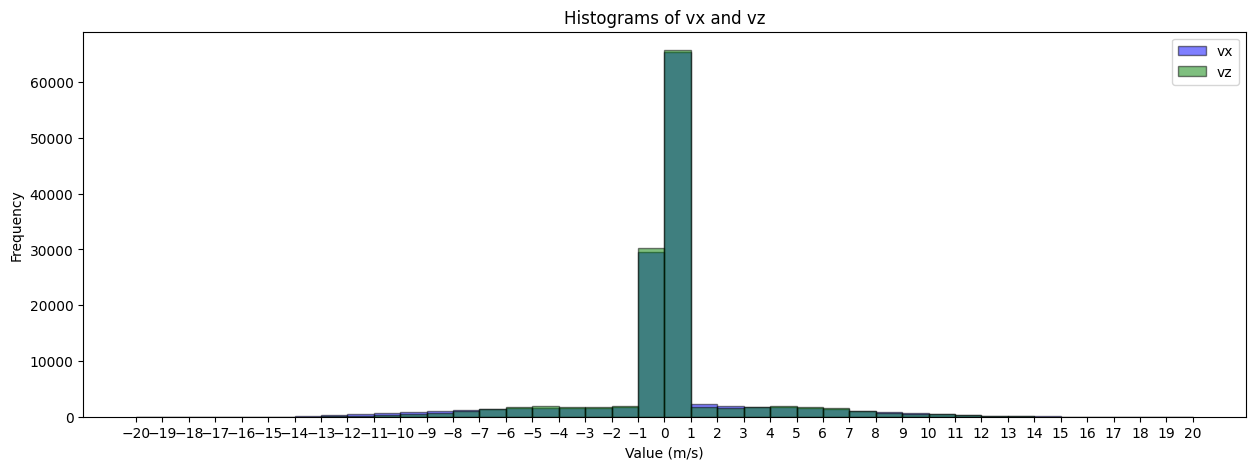

In [65]:
plt.figure(figsize=(15, 5))

plt.hist(vx_full, bins=40, range=(-20,20), alpha=0.5, label='vx', color='blue', edgecolor='black')
plt.hist(vz_full, bins=40, range=(-20,20), alpha=0.5, label='vz', color='green', edgecolor='black')

plt.title('Histograms of vx and vz')
plt.xlabel('Value (m/s)')
plt.ylabel('Frequency')
plt.legend(loc='upper right')
plt.xticks(np.arange(-20,21,1))
plt.show()


# plt.scatter(v_x,v_y, color='black', alpha=0.05)
# plt.title(' Velocities field')
# plt.xlim(-2.5,2.5)
# plt.ylim(-2.5,2.5)
# plt.xlabel('Vx')
# plt.ylabel('Vz')
# plt.show()

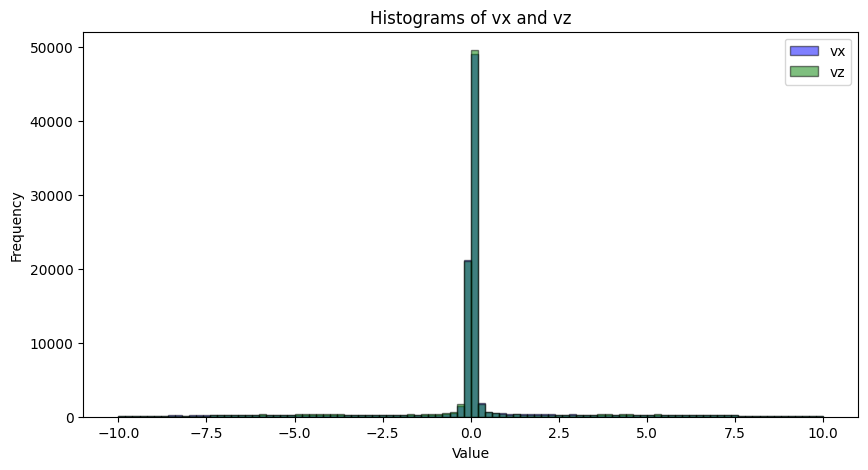

In [48]:
plt.figure(figsize=(10, 5))

plt.hist(vx_t, bins=100, range=(-10,10), alpha=0.5, label='vx', color='blue', edgecolor='black')
plt.hist(vz_t, bins=100, range=(-10,10), alpha=0.5, label='vz', color='green', edgecolor='black')

plt.title('Histograms of vx and vz')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend(loc='upper right')
# plt.xlim(-2,2)
plt.show()

In [14]:
z_scores_vx = zscore(v_x)
z_scores_vz = zscore(v_z)

# Define threshold for Z-score to identify outliers
threshold = 5

# Identify non-outlier indices
non_outliers_vx = np.abs(z_scores_vx) < threshold
non_outliers_vz = np.abs(z_scores_vz) < threshold

# Combine the masks to get common non-outliers
non_outliers = non_outliers_vx & non_outliers_vz

# Filter out outliers
v_x_cleaned = v_x[non_outliers]
v_z_cleaned = v_z[non_outliers]

In [15]:
from sklearn.preprocessing import MinMaxScaler

# Reshape data to fit scaler
v_x_cleaned = v_x_cleaned.reshape(-1, 1)
v_z_cleaned = v_z_cleaned.reshape(-1, 1)

# Initialize MinMaxScaler
scaler = MinMaxScaler()

# Fit and transform the data
v_x_normalized = scaler.fit_transform(v_x_cleaned)
v_z_normalized = scaler.fit_transform(v_z_cleaned)

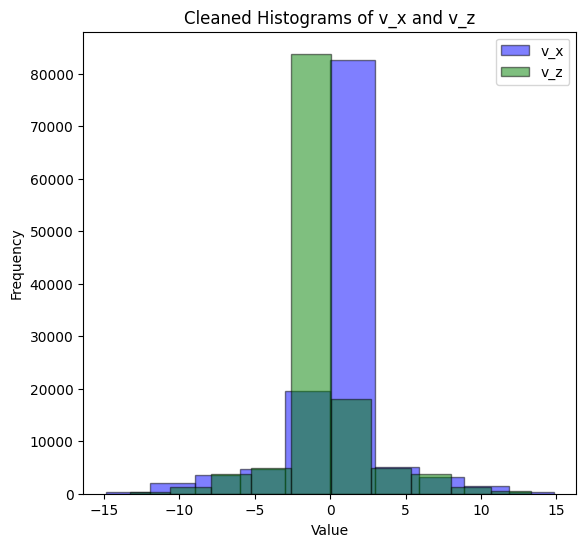

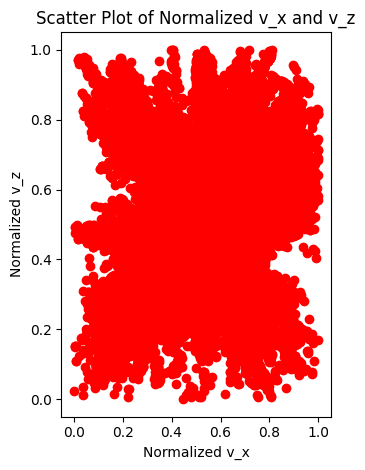

In [16]:
# import matplotlib.pyplot as plt

# Create histograms of the cleaned data
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.hist(v_x_cleaned, bins=10, alpha=0.5, label='v_x', color='blue', edgecolor='black')
plt.hist(v_z_cleaned, bins=10, alpha=0.5, label='v_z', color='green', edgecolor='black')
plt.title('Cleaned Histograms of v_x and v_z')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend(loc='upper right')
plt.show()

# Create a scatter plot of the normalized data
plt.subplot(1, 2, 2)
plt.scatter(v_x_normalized, v_z_normalized, color='red')
plt.title('Scatter Plot of Normalized v_x and v_z')
plt.xlabel('Normalized v_x')
plt.ylabel('Normalized v_z')

plt.tight_layout()
plt.show()

Total detect:  122943


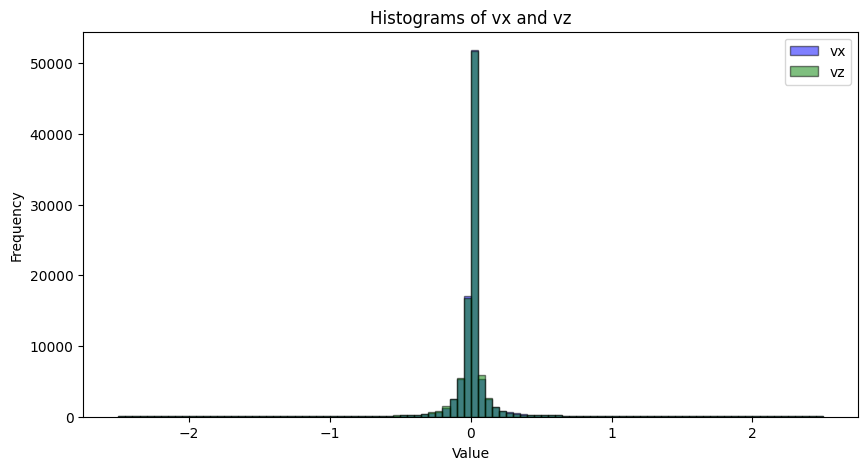

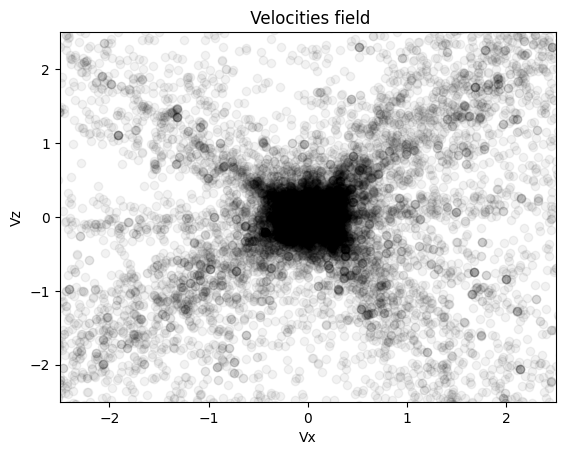

In [38]:
neg1 = np.array(neg_1)
neg2 = np.array(neg_2)
pos_ = np.array(pos)
n_dtc_np = np.array(n_dtc_list)

# print('Range ', rg/10)
# print('Total sum of neg: ',np.sum(neg1), ', Percent of total: ', round((np.sum(neg1)/np.sum(n_dtc_np)*100),ndigits=2),'%')
# print('Total sum of neg2: ',np.sum(neg2), ', Percent of total: ', round((np.sum(neg2)/np.sum(n_dtc_np)*100),ndigits=2),'%')
# print('Total sum of pos: ',np.sum(pos_), ', Percent of total: ', round((np.sum(pos_)/np.sum(n_dtc_np)*100),ndigits=2),'%')
print('Total detect: ', np.sum(n_dtc_np))
# Criando o histograma para vx e vy no mesmo gráfico
plt.figure(figsize=(10, 5))

plt.hist(v_x, bins=100, range=(-2.5,2.5), alpha=0.5, label='vx', color='blue', edgecolor='black')
plt.hist(v_y, bins=100, range=(-2.5,2.5), alpha=0.5, label='vz', color='green', edgecolor='black')

plt.title('Histograms of vx and vz')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend(loc='upper right')
# plt.xlim(-2,2)
plt.show()


plt.scatter(v_x,v_y, color='black', alpha=0.05)
plt.title(' Velocities field')
plt.xlim(-2.5,2.5)
plt.ylim(-2.5,2.5)
plt.xlabel('Vx')
plt.ylabel('Vz')
plt.show()